# The Eady instability

We use Dedalus to solve the classic Eady baroclinic instability problem.
For the Eady problem, the PV is assumed to be zero. Therefore we only
have the advection of the buoyancy on the top and bottom. We refer to
{cite:t}`Vallis_17` §9.5 for more details on the set-up of the problem and the
algebraic solution. Here we use Dedalus to recover their result. 

In [1]:
import numpy as np
import dedalus.public as d3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

plt.style.use('../subroutine/ryan_mplstyle.mplstyle')

In [2]:
# Numerics Parameters
Lz = 1
Nz = 128

dtype = np.complex128

# Bases
Lzt, Lzb = 0, -Lz

coords = d3.CartesianCoordinates('z')
dist = d3.Distributor(coords, dtype=dtype)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(Lzb, Lzt))

We define the fields

In [3]:
# Fields
omega = dist.Field()

q = dist.Field(name='q', bases=zbasis )
bt = dist.Field(name='bt' )
bb = dist.Field(name='bb' )

P0 = dist.Field(name='P0', bases=zbasis )

tau_P0 = dist.Field()
tau_P0t = dist.Field( )
tau_P0b = dist.Field( )

kx = dist.Field(name='kx')
ky = dist.Field(name='ky')
omega = dist.Field()

Note that for since we assumed the Fourier ansatz, $x$, $y$, and $t$-derivatives are replaced with miltiplication of $ik$, $i\ell$, and $-i\omega$.

In [4]:
# Substitutions
dx = lambda A: 1j*kx*A
dy = lambda A: 1j*ky*A
dz = lambda A: d3.Differentiate(A, coords['z'])
dt = lambda A: -1j*omega*A

z = dist.local_grids(zbasis)

lift_basis = zbasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

u = -dy(P0)
v =  dx(P0)

ut = u(z=Lzt); vt = v(z=Lzt); 
ub = u(z=Lzb); vb = v(z=Lzb); 

lap = lambda A: dx(dx(A))+dy(dy(A))+dz(dz(A))

Here we type out the linear instability problem. Note the use of tau fields to enforce the top and bottom boundary conditions.

In [5]:
# Problem
problem = d3.EVP([P0, tau_P0t, tau_P0b, \
                  bt, bb \
                  ], eigenvalue=omega, namespace=locals())

problem.add_equation("lap(P0) + lift(tau_P0t,-1) + lift(tau_P0b,-2) = 0")
problem.add_equation("dz(P0)(z=Lzt) - bt = 0"); problem.add_equation("dz(P0)(z=Lzb) - bb = 0")

problem.add_equation("dt(bt) + Lzt*dx(bt)-vt = 0")
problem.add_equation("dt(bb) + Lzb*dx(bb)-vb = 0")

{'eqn': Add(Add(Mul(Mul((-0-1j), <Field 134250387864896>), <Field 134250398235568>), Mul(-1, Mul(Mul(1j, <Field 134250388184400>), <Field 134250398235568>))), Mul(-1, interp(Mul(Mul(1j, <Field 134250388184400>), <Field 134250388118736>), z=-1))),
 'LHS': Add(Add(Mul(Mul((-0-1j), <Field 134250387864896>), <Field 134250398235568>), Mul(-1, Mul(Mul(1j, <Field 134250388184400>), <Field 134250398235568>))), Mul(-1, interp(Mul(Mul(1j, <Field 134250388184400>), <Field 134250388118736>), z=-1))),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'valid_modes': array([ True]),
 'M': Mul((-0-1j), <Field 134250398235568>),
 'L': Add(Mul(-1, Mul(Mul(1j, <Field 134250388184400>), <Field 134250398235568>)), Mul(-1, interp(Mul(Mul(1j, <Field 134250388184400>), <Field 134250388118736>), z=-1))),
 'domain': <dedalus.core.domain.Domain at 0x7a19cbd1a270>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

For each wavenumber $k$, we perform one Dedalus solve and find the most unstable vertical mode. This is done for a range of horizontal wavenumber $k$.

In [6]:
# Solver
k_ary = np.arange(0.01,4,0.03)
grow_ary = np.empty([k_ary.size])
c_ary_1 = np.empty([k_ary.size], dtype=complex)
c_ary_2 = np.empty([k_ary.size], dtype=complex)

for ix in range(k_ary.size):
    kx['g'] = k_ary[ix]; ky['g'] = 0

    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
    evals = solver.eigenvalues
    # print(evals.shape)

    e_loc = np.argmax(np.imag(evals))
    grow_ary[ix] = np.imag(evals[e_loc])
    
    if abs(np.imag(evals[e_loc])) > 1e-15:
        c_ary_1[ix] = evals[e_loc]/k_ary[ix]
        c_ary_2[ix] = evals[e_loc]/k_ary[ix]
    else:
        c_ary_1[ix] = np.min(evals[evals<np.inf])/k_ary[ix]
        c_ary_2[ix] = np.max(evals[evals<np.inf])/k_ary[ix]

2025-06-12 10:08:59,215 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2025-06-12 10:08:59,259 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s
2025-06-12 10:08:59,297 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s
2025-06-12 10:08:59,330 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.2e+01/s
2025-06-12 10:08:59,366 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s
2025-06-12 10:08:59,405 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s
2025-06-12 10:08:59,444 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.9e+01/s
2025-06-12 10:08:59,484 subsystems 0/1 INFO :: Building subproblem matrices 

For the $k$ with the highest growth rate, we also find the eigenvector. This gives us the vertical profile of the most unstable mode.

In [10]:
k_max = k_ary[np.argmax(grow_ary)]

kx['g'] = k_max; ky['g'] = 0

solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
evals = solver.eigenvalues

loc_grow = np.argmax(np.imag(evals))

solver.set_state(loc_grow,0)
P0_evec = solver.state[0]['g'] # index 0 because P0 is the first element of the d3.EVP statement

2025-06-12 10:10:46,322 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+01/s


The below plot matches exactly {cite:t}`Vallis_17` Fig. 9.10.

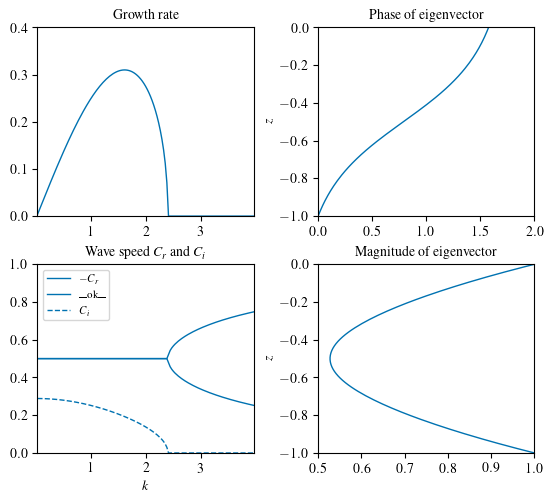

In [13]:
# plot
fig=plt.figure(figsize=(5.5,5))

plt.subplot(2,2,1)
plt.plot(k_ary,grow_ary)
plt.ylim(0,0.4)

k_max = k_ary[np.argmax(grow_ary)]
plt.title("Growth rate")

plt.subplot(2,2,3)
plt.plot(k_ary,-np.real(c_ary_1),color=(0,0.4453125,0.6953125))
plt.plot(k_ary,-np.real(c_ary_2),color=(0,0.4453125,0.6953125))

plt.plot(k_ary,np.imag(c_ary_1),'--')

plt.legend(["$-C_r$",'__ok__',"$C_i$"])
plt.title("Wave speed $C_r$ and $C_i$")
plt.ylim(0,1)
plt.xlabel("$k$")

plt.subplot(2,2,2)
plt.plot(np.angle(P0_evec)-np.angle(P0_evec[0]),z[0].ravel())
plt.xlim(0,2)
plt.title("Phase of eigenvector")
plt.ylim(-1,0)
plt.ylabel("$z$")

plt.subplot(2,2,4)
plt.plot(np.abs(P0_evec)/np.abs(P0_evec[0]),z[0].ravel())
plt.xlim(0.5,1)
plt.title("Magnitude of eigenvector")
plt.ylim(-1,0)
plt.ylabel("$z$")

fig.tight_layout(pad=0.6)
plt.show()

We evaluate for the $b$ and $v$ fields of the most unstable mode.

In [15]:
b = dist.Field(bases=zbasis )
v = dist.Field(bases=zbasis )

# Problem
problem_morefields = d3.LBVP([v, b], namespace=locals())

problem_morefields.add_equation("v = dx(P0)")
problem_morefields.add_equation("b = dz(P0)")

{'eqn': Add(Convert(<Field 134250239443376>), Mul(-1, Diff(<Field 134250388118736>))),
 'LHS': <Field 134250239443376>,
 'RHS': Diff(<Field 134250388118736>),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'valid_modes': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  T

In [16]:
P0['g'] = P0_evec

# Solver
solver_morefields = problem_morefields.build_solver()
solver_morefields.solve()

2025-06-12 10:14:11,741 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.9e+01/s


The below plot matches exactly {cite:t}`Vallis_17` Fig. 9.12.

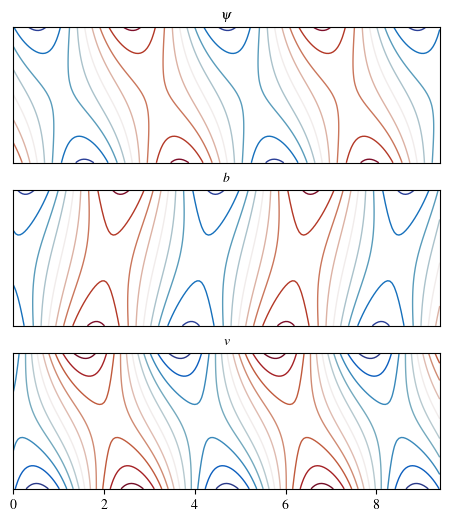

In [17]:
x = np.arange(0,3*np.pi,0.05)
phs_corr = np.exp(1j*1.5*x)

fig=plt.figure(figsize=(5.5,6))

plt.subplot(3,1,1)
P0eig_mat = np.outer(P0['g'],phs_corr)
plt.contour(x,z[0].ravel(),P0eig_mat.real, 10, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.xticks([]); plt.yticks([])
plt.title(r"$\psi$")

plt.subplot(3,1,2)
beig_mat = np.outer(b['g'],phs_corr)
plt.contour(x,z[0].ravel(),beig_mat.real, 10, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.xticks([]); plt.yticks([])
plt.title("$b$")

plt.subplot(3,1,3)
veig_mat = np.outer(v['g'],phs_corr)
plt.contour(x,z[0].ravel(),veig_mat.real, 10, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.yticks([])
plt.title("$v$")

plt.show()

The below plot matches exactly {cite:t}`Vallis_17` Fig. 9.11. This is left as an excercise for the reader.